In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

# Results Analysis

In [2]:
final_profits = pd.read_csv('simulations.csv')

## Treat None vs. Treat all visualization

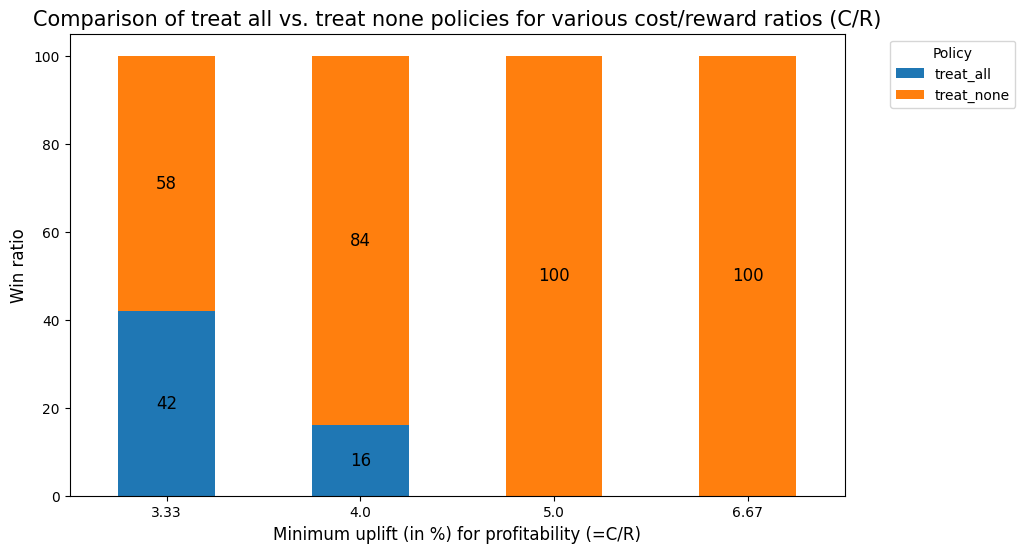

In [ ]:
tn_v_ta = (final_profits.groupby(['cost_reward_ratio'])[['treat_none', 'treat_all']].apply(lambda x: (x['treat_none']>x['treat_all']).sum()) / 50 *100).reset_index().rename(columns = {0:'treat_none'})

tn_v_ta['treat_all'] = 100 - tn_v_ta['treat_none']

tn_v_ta['cost_reward_ratio'] = round(tn_v_ta['cost_reward_ratio'] * 100,2)

tn_v_ta

df= pd.melt(tn_v_ta,
                    id_vars = ['cost_reward_ratio'],
                    value_vars = ['treat_none', 'treat_all'],
                    value_name='win_ratio',
                    var_name = 'policy')

df_pivot = df.pivot(index='cost_reward_ratio', columns='policy', values='win_ratio')

fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.set_facecolor('white')

df_pivot.plot(kind='bar', stacked=True, ax=ax, color=['#1f77b4', '#ff7f0e'])

# Customizing the x and y axis labels
ax.set_xlabel('Minimum uplift (in %) for profitability (=C/R)', fontsize=12)
ax.set_ylabel('Win ratio', fontsize=12)

# Adding annotations
for idx, cost_reward_ratio in enumerate(df_pivot.index):
    cumulative_sum = 0
    for policy in df_pivot.columns:
        value = df_pivot.loc[cost_reward_ratio, policy]
        if value != 0:
            cumulative_sum += value
            ax.text(idx, cumulative_sum - value / 2, f'{value:.0f}', ha='center', va='center', color='black', fontsize=12)

# Setting the title
ax.set_title('Comparison of treat all vs. treat none policies for various cost/reward ratios (C/R)', fontsize=15)

# Adjusting the legend position
legend = ax.legend(title='Policy', bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True)
legend.get_frame().set_facecolor('white')

# Adjusting x-ticks
plt.xticks(rotation=0)

plt.savefig('treat_all_vs_treat_none.png', bbox_inches='tight')

plt.show()

## Sunburst chart: which policy wins?

In [ ]:
final_profits.columns

Index(['cost_reward_ratio', 'treat_none', 'treat_none_phi', 'treat_all',
       'tret_all_phi', 's-learner_policy_1', 's-learner_policy_1_phi',
       's-learner_policy_2', 's-learner_policy_2_phi',
       'double_machine_learning_policy_1',
       'double_machine_learning_policy_1_phi',
       'double_machine_learning_policy_2',
       'double_machine_learning_policy_2_phi', 'x-learner_policy_1',
       'x-learner_policy_1_phi', 'x-learner_policy_2',
       'x-learner_policy_2_phi', 'causal_forest_policy_1',
       'causal_forest_policy_1_phi', 'causal_forest_policy_2',
       'causal_forest_policy_2_phi'],
      dtype='object')

In [ ]:
columns_to_keep = [
    'cost_reward_ratio', 'treat_none', 'treat_all',
    's-learner_policy_1', 's-learner_policy_2',
    'double_machine_learning_policy_1', 'double_machine_learning_policy_2',
    'x-learner_policy_1', 'x-learner_policy_2',
    'causal_forest_policy_1', 'causal_forest_policy_2'
]

df_filtered = final_profits[columns_to_keep]

df_filtered['dataset'] = list(range(1,51)) * 4

# Melting the dataframe
df_melted = pd.melt(df_filtered, id_vars=['cost_reward_ratio', 'dataset'], var_name='method', value_name='profit')

# Creating the 'policy' column
df_melted['policy'] = df_melted['method'].apply(lambda x: 'policy_1' if x.endswith('policy_1') else ('policy_2' if x.endswith('policy_2') else np.nan))

# Stripping the '_policy_1' and '_policy_2' parts from the 'method' column
df_melted['method'] = df_melted['method'].str.replace('_policy_1', '').str.replace('_policy_2', '')

# Display the final dataframe
df_melted

,cost_reward_ratio,dataset,method,profit,policy
0,0.033333,1,treat_none,957900.0,NaN
1,0.033333,2,treat_none,961560.0,NaN
2,0.033333,3,treat_none,974760.0,NaN
3,0.033333,4,treat_none,960240.0,NaN
4,0.033333,5,treat_none,953940.0,NaN
...,...,...,...,...,...
1995,0.040000,46,causal_forest,817670.0,policy_2
1996,0.040000,47,causal_forest,815026.0,policy_2
1997,0.040000,48,causal_forest,810656.0,policy_2
1998,0.040000,49,causal_forest,815248.0,policy_2


In [ ]:
import plotly.graph_objects as go

In [ ]:
# Step 1: Identify the highest profit method for each cost_reward_ratio
df_melted['rank'] = df_melted.groupby(['cost_reward_ratio', 'dataset'])['profit'].rank(method='dense', ascending=False)
df_max_profits = df_melted[df_melted['rank'] == 1]

# Step 2: Calculate the percentage of times each method had the highest profit within each cost_reward_ratio
method_counts = df_max_profits.groupby(['cost_reward_ratio', 'method']).size().reset_index(name='count')
total_counts = method_counts.groupby('cost_reward_ratio')['count'].transform('sum')
method_counts['percentage'] = method_counts['count'] / total_counts

# Step 3: Calculate the percentage of times policy_1 or policy_2 had the highest profits for each method
policy_counts = df_max_profits.dropna(subset=['policy']).groupby(['cost_reward_ratio', 'method', 'policy']).size().reset_index(name='count')
policy_total_counts = policy_counts.groupby(['cost_reward_ratio', 'method'])['count'].transform('sum')
policy_counts['percentage'] = policy_counts['count'] / policy_total_counts

# Merging the data for sunburst chart
merged = pd.merge(method_counts, policy_counts, on=['cost_reward_ratio', 'method'], how='left', suffixes=('', '_policy'))
merged['percentage_policy'].fillna(0, inplace=True)

merged['cost_reward_ratio'] = round(merged['cost_reward_ratio'] * 100,2)
merged['percentage'] = round(merged['percentage'] * 100,2)
merged['percentage_policy'] = round(merged['percentage_policy'] * 100,2)


# Preparing data for sunburst chart
sunburst_data = {
    'ids': [],
    'labels': [],
    'parents': [],
    'values': []
}

# Adding cost_reward_ratio
for cost_reward_ratio in merged['cost_reward_ratio'].unique():
    sunburst_data['ids'].append(f'cost_reward_ratio_{cost_reward_ratio}')
    sunburst_data['labels'].append(f'CRR = {cost_reward_ratio}%')
    sunburst_data['parents'].append('')
    sunburst_data['values'].append(merged[merged['cost_reward_ratio'] == cost_reward_ratio]['percentage'].sum())

# Adding methods and policies
for _, row in merged.iterrows():
    cost_reward_ratio_id = f'cost_reward_ratio_{row["cost_reward_ratio"]}'
    method_id = f'{cost_reward_ratio_id}_{row["method"]}'
    
    # Adding method layer
    if method_id not in sunburst_data['ids']:
        sunburst_data['ids'].append(method_id)
        sunburst_data['labels'].append(row['method'])
        sunburst_data['parents'].append(cost_reward_ratio_id)
        sunburst_data['values'].append(row['percentage'])
    
    # Adding policy layer
    if not pd.isna(row['policy']):
        policy_id = f'{method_id}_{row["policy"]}'
        sunburst_data['ids'].append(policy_id)
        sunburst_data['labels'].append(row['policy'])
        sunburst_data['parents'].append(method_id)
        sunburst_data['values'].append(row['count_policy'])


sunburst_data2 = sunburst_data.copy()
for index in range(len(sunburst_data2['labels'])):
    if 'policy' not in sunburst_data2['labels'][index]:
        sunburst_data2['values'][index]=0

fig = go.Figure(go.Sunburst(
    ids=sunburst_data2['ids'],
    labels = sunburst_data2['labels'],
    parents=sunburst_data2['parents'],
    values=sunburst_data2['values']
))
fig.update_layout(
    height=600,
    width=600,
    margin = dict(t=0, l=0, r=0, b=0))
# fig.update_layout(title_text="Sunburst Chart of Profits", title_x=0.5)
fig.show()

fig.write_image("model_performance.png")


## 3 Profits per model

In [15]:
cost_reward_ratios = final_profits['cost_reward_ratio'].unique()

cols = ['s-learner_policy_1','s-learner_policy_2',
        'causal_forest_policy_1', 'causal_forest_policy_2',
        'double_machine_learning_policy_1', 'double_machine_learning_policy_2',
        'x-learner_policy_1', 'x-learner_policy_2']

new_profits= pd.DataFrame()

for ratio in cost_reward_ratios:
    for col in cols:
        new_profits[col] = (final_profits[col] - final_profits['treat_none']) / test_set_size

new_profits['cost_reward_ratio'] = [j for i in cost_reward_ratios for j in [i]*50]

new_profits

,s-learner_policy_1,s-learner_policy_2,causal_forest_policy_1,causal_forest_policy_2,double_machine_learning_policy_1,double_machine_learning_policy_2,x-learner_policy_1,x-learner_policy_2,cost_reward_ratio
0,0.426900,0.424292,0.360406,0.277808,0.014667,-0.014100,0.341316,0.381084,0.033333
1,0.238532,0.262687,0.376283,0.118396,-0.050504,-0.016368,0.183908,0.274217,0.033333
2,0.113180,0.107358,0.059954,-0.070917,0.113558,0.096547,0.302871,0.220273,0.033333
3,0.391404,0.478727,0.361086,0.540685,0.519478,0.522086,0.416656,0.393218,0.033333
4,0.105997,0.186818,0.296331,0.194114,0.343508,0.360028,0.154309,0.320071,0.033333
...,...,...,...,...,...,...,...,...,...
195,0.154573,0.117036,0.078515,0.224356,-0.090385,-0.062487,-0.077646,-0.059312,0.040000
196,0.013722,0.024798,0.060332,0.039239,0.061580,0.019430,-0.151209,-0.145123,0.040000
197,0.247793,0.295311,0.245034,0.263784,0.144858,0.172794,0.032661,0.137109,0.040000
198,0.197970,0.140019,0.208025,0.174797,0.109248,0.072731,0.079120,0.187537,0.040000


___

### Boxplots for each cost-to-reward ratio

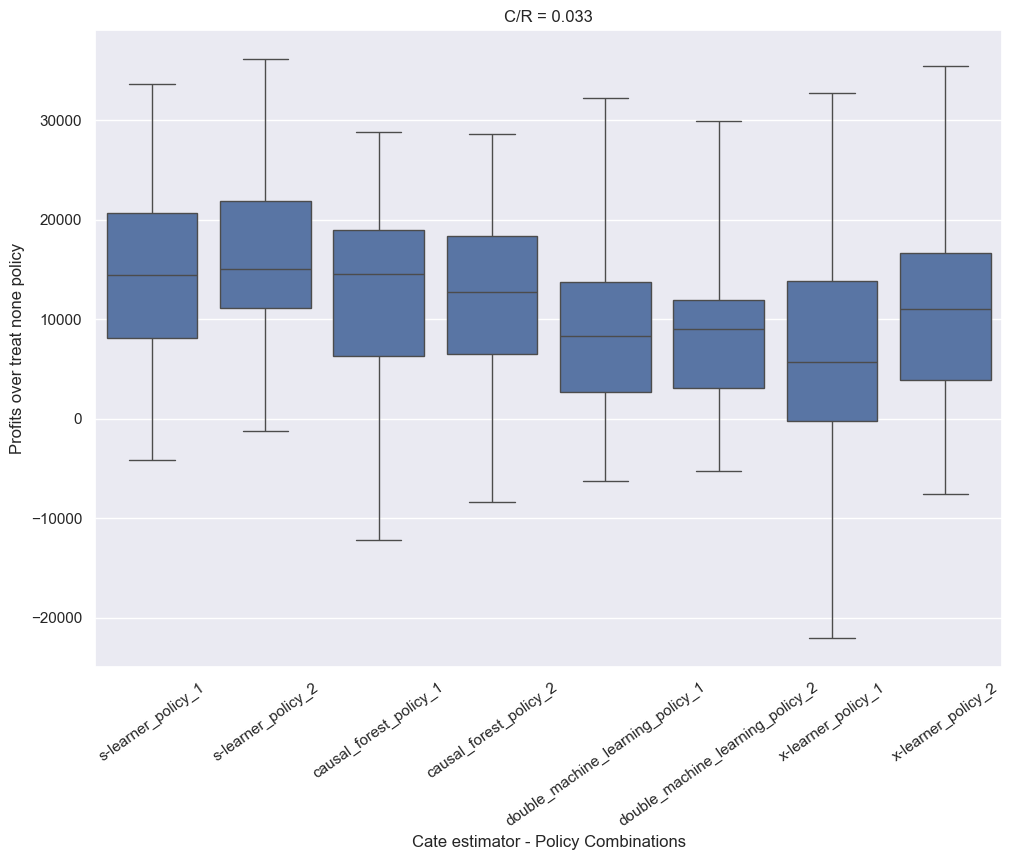

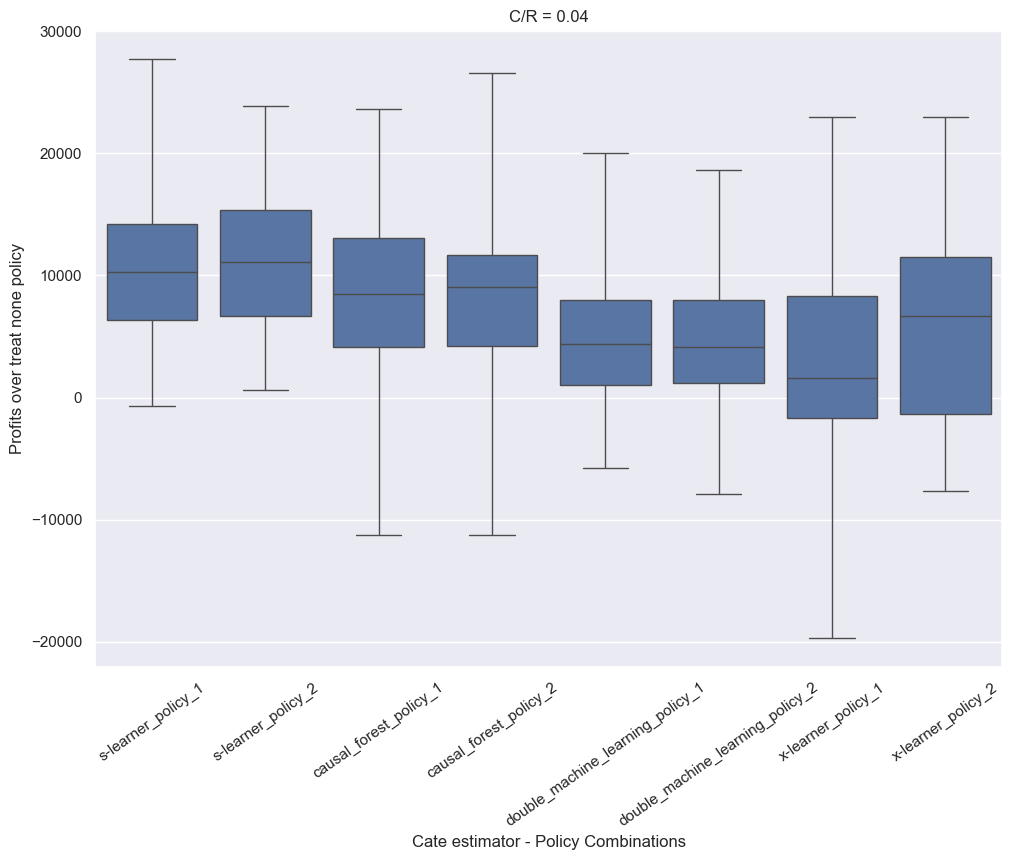

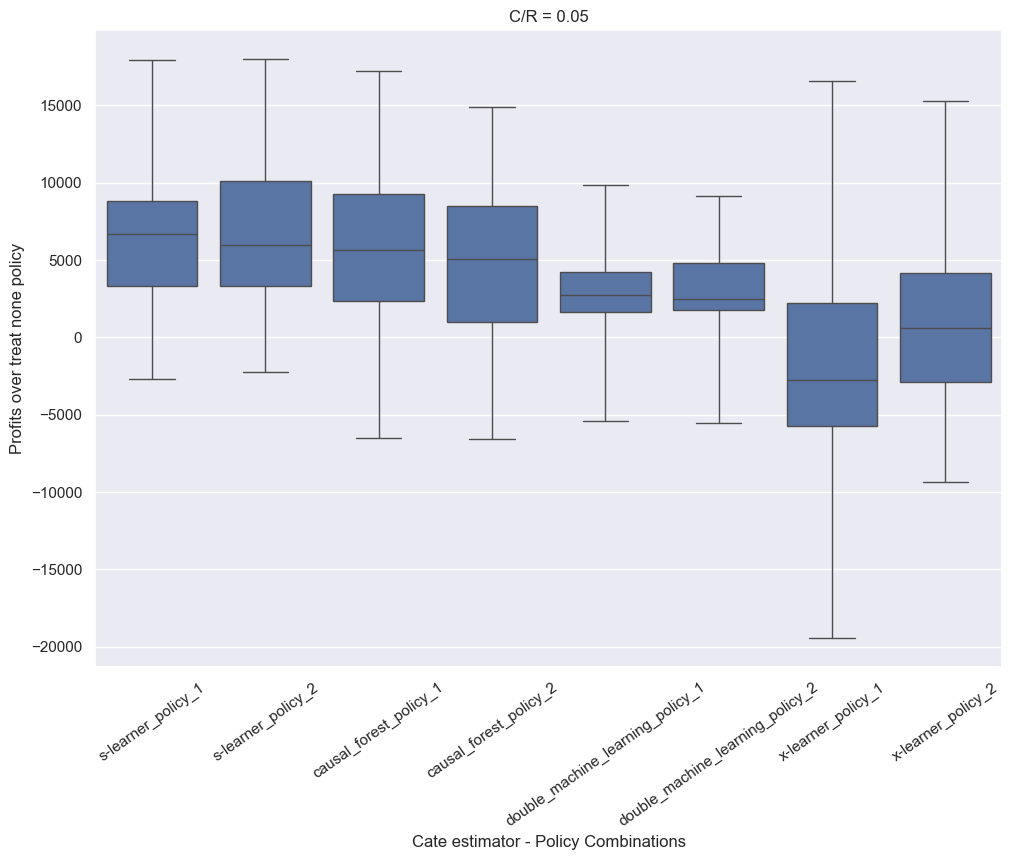

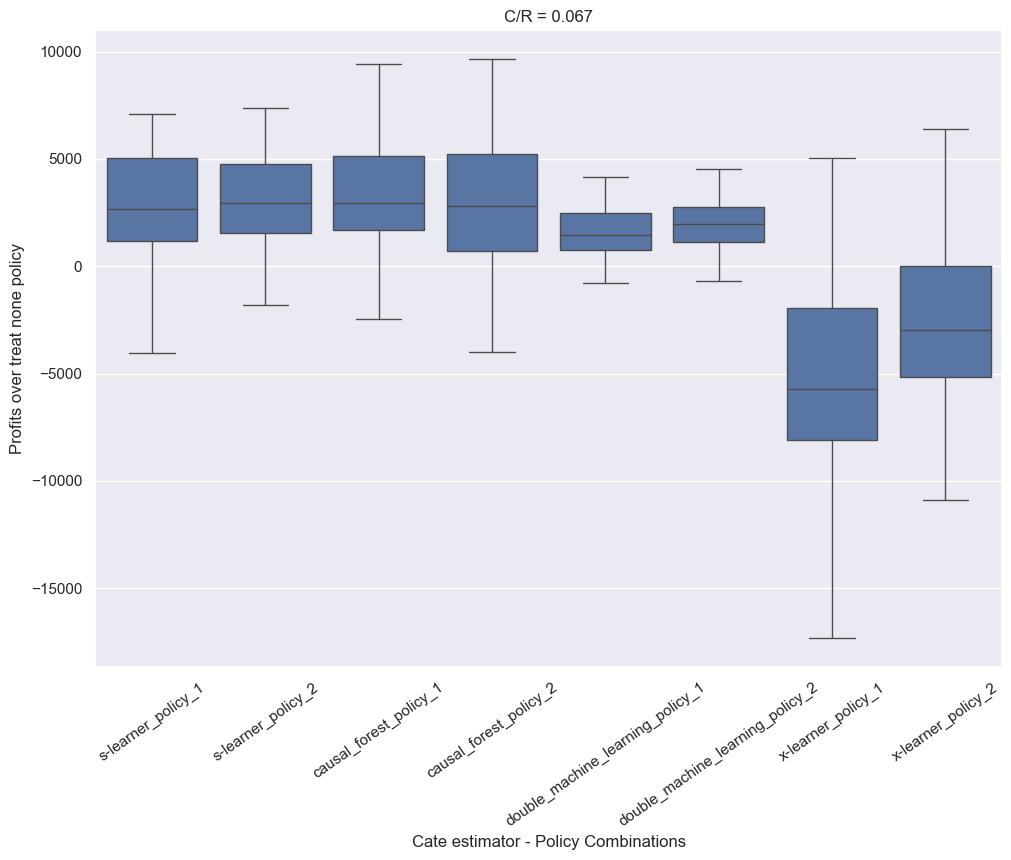

In [ ]:
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})


for ratio in [0.033, 0.04, 0.05, 0.067]:

    plt.figure()

    sns.boxplot(pd.melt(new_profits[new_profits['cost_reward_ratio']==ratio].drop(columns = ['cost_reward_ratio']),
                    value_vars = new_profits.drop(columns = ['cost_reward_ratio']).columns),
            x = 'variable',
            y = 'value',
            whis = (0,100))

    plt.xticks(rotation=35)

    plt.title(f'C/R = {ratio}')
    plt.ylabel('Profits over treat none policy')
    plt.xlabel('Cate estimator - Policy Combinations')

    plt.show()

___

### Average Profits versus treat none policy

#### Scale profits to the whole dataset.

In [65]:
df  = new_profits.groupby(['cost_reward_ratio']).agg(['mean', 'var']).T.unstack(level=1)

df2 = df.copy()
for col in df2.columns:
    if 'mean' in col[1]:
        df2[col] = df2[col] * dataset_size
    
    if 'var' in col[1]:
        df2[col] = df2[col]* (dataset_size)**2
        df2[(col[0], 'std')] = np.sqrt(df2[col])
        df2.drop(columns = col, inplace=True)

In [66]:
new_cols = [(0.0333333333333333, 'mean'),(0.0333333333333333,  'std'),
             (              0.04, 'mean'),(              0.04,  'std'),
             (              0.05, 'mean'), (              0.05,  'std'),
              (0.0666666666666666, 'mean'),  (0.0666666666666666,  'std')]

multi_cols = pd.MultiIndex.from_tuples(new_cols, names=['cost_reward_ratio', None])

df2 = pd.DataFrame(df2, columns = multi_cols)

df2.columns = pd.MultiIndex.from_tuples([('3.33%', 'mean'),
               ('3.33%',  'std'),
               ('4%', 'mean'),
               ('4%', 'std'),
               ('5%', 'mean'),
               ('5%', 'std'),
               ('6%', 'mean'),
               ('6%',  'std')],
               names=['cost_reward_ratio', None])


df2

cost_reward_ratio                        3.33%                          4%  \
                                          mean           std          mean   
s-learner_policy_1                49673.667029  27560.806982  34130.426596   
s-learner_policy_2                53030.051769  25736.587160  37212.793519   
causal_forest_policy_1            41675.521860  30989.264948  26969.543266   
causal_forest_policy_2            39604.646216  28256.292438  26836.936786   
double_machine_learning_policy_1  28635.395496  26984.820397  16241.358854   
double_machine_learning_policy_2  28433.284010  24967.905563  15030.290820   
x-learner_policy_1                22736.274831  34069.575572   8363.013100   
x-learner_policy_2                36960.921251  33002.839303  18405.886156   

cost_reward_ratio                                         5%                \
                                           std          mean           std   
s-learner_policy_1                19441.485747  20548.134503  15895.136495   
s-learner_policy_2                18928.280159  21866.061481  14683.904402   
causal_forest_policy_1            24047.443094  17917.616823  17139.901611   
causal_forest_policy_2            25316.173591  15383.819162  16950.563941   
double_machine_learning_policy_1  19086.156853   9125.833878   9496.678156   
double_machine_learning_policy_2  18589.415978   9423.464720   9189.387800   
x-learner_policy_1                27431.397469  -6477.573077  21179.894179   
x-learner_policy_2                25313.143540   3685.499616  19157.897049   

cost_reward_ratio                           6%                
                                          mean           std  
s-learner_policy_1                 9572.213437   8591.032438  
s-learner_policy_2                10567.829293   7457.282688  
causal_forest_policy_1            10849.051084  10241.876586  
causal_forest_policy_2             8918.119301  11228.347021  
double_machine_learning_policy_1   5458.611010   4251.162359  
double_machine_learning_policy_2   6189.280720   3741.139797  
x-learner_policy_1               -17134.785008  15608.493591  
x-learner_policy_2                -9236.161402  12396.548968

### Function for styling the dataframe

In [67]:
def style_dataframe_with_title(df, title):
    # Create a boolean mask for columns to highlight (e.g., every second column)
    highlight_columns = [(i+1) % 2 == 1 for i in range(df.shape[1])]
    
    styled = df.style.format("{:.2f}") \
                     .set_caption(title) \
                     .set_table_styles([
                         {'selector': 'caption',
                          'props': [('color', 'black'),
                                    ('font-size', '18px'),
                                    ('font-weight', 'bold'),
                                    ('text-align', 'center'),
                                    ('padding', '10px')]},
                         {'selector': '',
                          'props': [('background-color', 'white'),
                                    ('color', 'black'),
                                    ('border', '1px solid black')]},
                         {'selector': 'thead th',
                          'props': [('background-color', '#f0f0f0'),
                                    ('color', 'black'),
                                    ('border', '1px solid black')]},
                         {'selector': 'tbody tr:nth-child(even)',
                          'props': [('background-color', '#f9f9f9')]},
                         {'selector': 'tbody tr:hover',
                          'props': [('background-color', '#f5f5f5')]}
                     ])
    
    for col, to_highlight in zip(df.columns, highlight_columns):
        if to_highlight:
            styled = styled.highlight_max(subset=[col], color='lightgreen')
    
    return styled



## Table with profits over treat none policy (scaled on the size of the original dataset)

In [ ]:
# Apply the styling with a title

styled_df = style_dataframe_with_title(df2, "Profits over treat none policy")

styled_df

In [ ]:
phi_cols = [col for col in final_profits.columns if col.endswith('phi') & ('tre' not in col)]

style_dataframe_with_title(final_profits[phi_cols + ['cost_reward_ratio']].groupby(['cost_reward_ratio']).agg(['mean', 'std']).T.unstack(level=1).round(2), 'Percentage of users targeted')


for col, to_highlight in zip(df.columns, highlight_columns):
    if to_highlight:
        styled = styled.highlight_max(subset=[col], color='lightgreen')

____